# Prosit data analysis
My goal:
To understand why the transformer model has different performance per intensity.


Table of contents:
- [Intensities](#Intensities)
- [Sequences](#Sequences)
- [Collision energy](#Collision-energy)

In [1]:
import h5py
import dask
dask.config.set({"dataframe.query-planning": True})
import dask.dataframe as dd
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
filename = "traintest_hcd.hdf5"

In [3]:
f = h5py.File(filename)

In [4]:
f.keys()

<KeysViewHDF5 ['collision_energy', 'collision_energy_aligned', 'collision_energy_aligned_normed', 'intensities_raw', 'masses_pred', 'masses_raw', 'method', 'precursor_charge_onehot', 'rawfile', 'reverse', 'scan_number', 'score', 'sequence_integer', 'sequence_onehot']>

The shape of the intensities is `(6787933, 174)`. This means there are 174 values per record. 174 is the resolution.

Precursor charge: charge of thing going into mass spec, refers to whole sequence.
Collision energy: feature of mass spectrometer. Can be different per input.
Lenght 30 sequence means 29 different kinds of ions

y and b are 2 ions, 2 sides
ions can have charge up to 3

Intensities are for certain ions, we consider 174 different types of ions

In [48]:
f["masses_raw"].shape

(6787933, 174)

## Intensities

In [23]:
intensities = da.array(f["intensities_raw"])
a.shape

(6787933, 174)

## Sequences
The shape of sequences is`(6787933, 30)`. This means that every record has a sequence of length 30.

In [29]:
sequences = da.array(f["sequence_integer"])
sequences.shape

(6787933, 30)

In [37]:
sequences[0].compute()

array([19,  4, 18, 20, 13, 18, 12, 16, 17,  5, 15, 18, 10, 18, 16,  6,  1,
       17, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

### Getting sequence length
I'm assuming that the value `0` is the padding value. If I find the index of the first occurence of the value 0 I know the length of the sequence.

[(0, 18754),
 (7, 300709),
 (8, 436717),
 (9, 568136),
 (10, 663563),
 (11, 685975),
 (12, 653713),
 (13, 588396),
 (14, 551786),
 (15, 451905),
 (16, 383824),
 (17, 334986),
 (18, 268115),
 (19, 229419),
 (20, 177265),
 (21, 116717),
 (22, 75551),
 (23, 62547),
 (24, 59088),
 (25, 41523),
 (26, 36190),
 (27, 30642),
 (28, 29631),
 (29, 22781)]

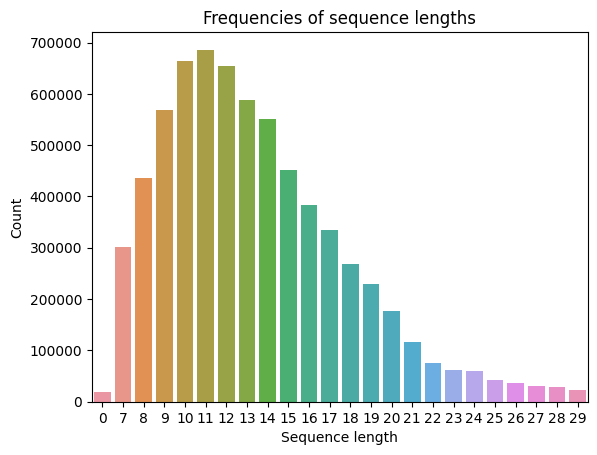

In [78]:
lengths = da.argmax(sequences == 0, axis=1)

unique_lengths, len_counts = da.unique(lengths, return_counts=True)

fig,ax = plt.subplots()
unique_lengths = unique_lengths.compute()
len_counts = len_counts.compute()

sns.barplot(x=unique_lengths, y=len_counts, ax=ax)
ax.set_title("Frequencies of sequence lengths")
ax.set_xlabel("Sequence length")
ax.set_ylabel("Count")

list(zip(unique_lengths, len_counts))

There are 18754 sequences of length 0, that is weird. Let's get the list of indices of sequences with length 0

In [90]:
zero_length_idx, = da.where(lengths==0)

zero_length_idx = zero_length_idx.compute()

Inspect the first couple sequences. Looks like the zero length indices actually refer to the ones that have full length.

In [93]:
sequences[zero_length_idx[:10]].compute()

array([[ 6,  4,  2, 16, 13, 13,  6,  1, 13,  6, 13, 13,  1, 15,  7, 11,
        18, 19, 13, 16, 10, 16, 13, 20, 13,  2, 13,  1, 13,  9],
       [11, 11, 14, 14, 13, 15, 18,  4, 17,  3, 17,  8,  6,  1,  6,  4,
         6, 13, 14, 14,  1, 18, 13, 19, 16,  1, 19, 18, 17, 15],
       [11,  1,  3,  7, 10, 11, 10,  1,  4,  6, 20, 15, 10, 18, 14, 15,
        13, 13, 16,  1,  1,  1,  1,  7,  6, 13,  7,  1, 10, 15],
       [10,  8,  7, 16,  6, 16, 16,  4, 12,  4, 16, 14,  4,  3,  4,  6,
         1,  3, 10,  8, 13, 20, 17,  6, 10,  9,  1,  3, 12, 15],
       [14, 14, 14,  1, 16,  4,  6, 15, 13, 19, 16,  3, 14,  1,  4,  6,
        13,  4,  6,  4,  6,  1, 21, 13, 10,  5,  6, 15, 17,  9],
       [16,  9,  5, 13,  4, 10, 13,  5,  6,  1,  5, 18, 13,  6,  6, 13,
        10, 20,  3,  6, 10, 14,  1,  6,  1,  1,  3,  7, 18, 15],
       [ 1, 16, 14, 16, 18, 16, 16, 20, 10,  1, 19, 20, 14, 14,  9, 13,
         6, 14,  1, 13, 15, 10, 10,  8, 20,  3,  1, 16, 12, 15],
       [ 1, 10, 10, 16,  4, 13, 13,  4, 1

In [ ]:
sequences[zero_length_idx[0]].compute()

To be sure, let's check how many sequences start with 0 (spoiler alert: no sequences start with 0)

In [94]:
da.count_nonzero(sequences[:, 0] == 0).compute()

0

## Collision energy

In [8]:
collision_energy = da.array(f["collision_energy"])

In [9]:
print(f"Min: {collision_energy.min().compute()}")
print(f"Max: {collision_energy.max().compute()}")
print(f"Unique values: {da.unique(collision_energy).compute()}")

Min: 20.0
Max: 35.0
Unique values: [20. 23. 25. 28. 30. 35.]


In [14]:
values, counts = da.unique(collision_energy, return_counts=True)
values = values.compute()
counts = counts.compute()

Text(0, 0.5, 'Count')

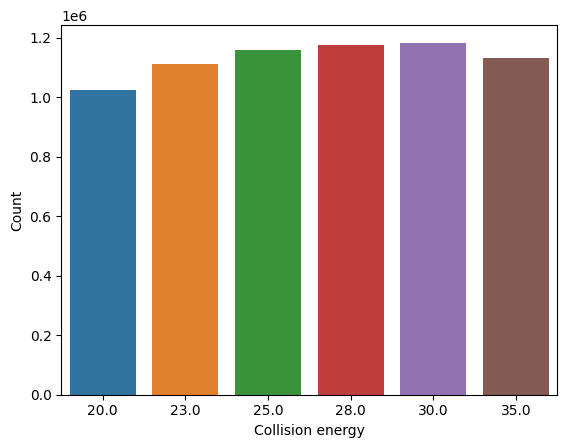

In [21]:
fix, ax = plt.subplots()
sns.barplot(x=values, y=counts, ax=ax)
ax.set_xlabel("Collision energy")
ax.set_ylabel("Count")